In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import SCORERS, make_scorer, mean_squared_error
from haversine import haversine
import itertools

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(16,9)
plt.rcParams['axes.grid'] = False

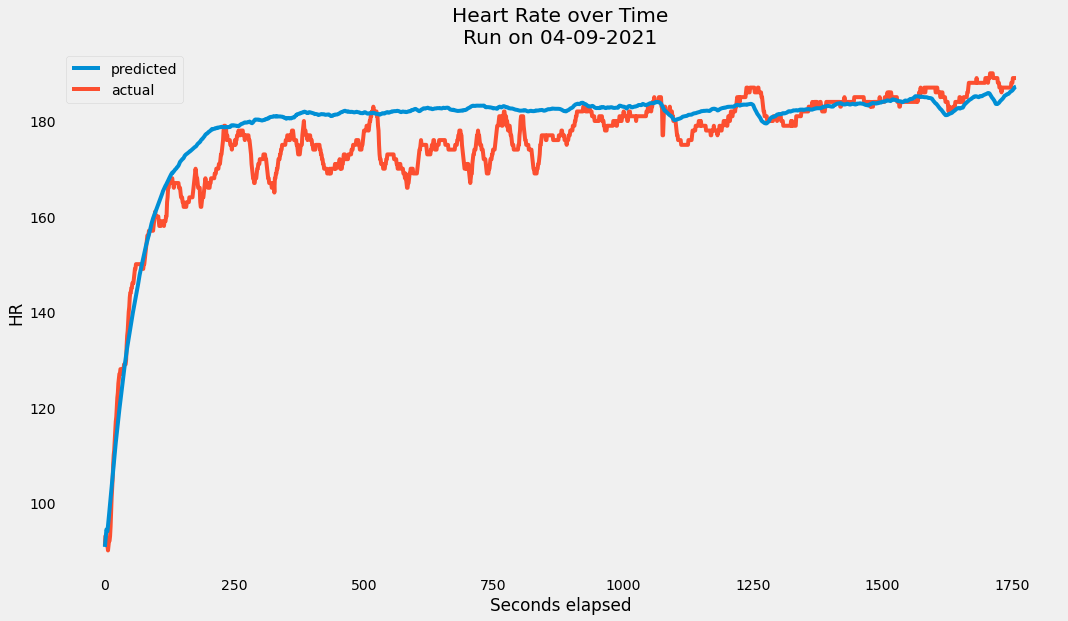

In [2]:
drop_list = ['lat', 'lon', 'prev_lat', 'prev_lon', 'ns1:ele', 'ns1:time', 'ns1:time2', 'speed_gain']
X_fields = len(drop_list) - 7

data = pd.DataFrame()

for i in range(1,9):

    df = (pd.read_excel(f'Run Sample {i}.xlsx', converters = {'ns1:time': pd.to_datetime, 'ns1:time2': pd.to_datetime})
          [['ns1:time', 'lat', 'lon', 'ns1:ele', 'ns1:time2', 'ns2:hr', 'ns2:cad']]
         )
    df.rename(columns={'ns2:hr':'hr', 'ns2:cad': 'cadence'}, inplace = True)

    df['depth'] = (df['ns1:time2'] - df['ns1:time']).apply(lambda x: x.total_seconds())/60

    df[['prev_lat', 'prev_lon']] = df[['lat', 'lon']].shift()
    df['speed'] = ((df.apply(lambda x: haversine((x['prev_lat'], x['prev_lon']), (x['lat'], x['lon'])), axis = 1))*60)
    distance_vec = df['speed'].copy()
    df['speed_gain'] = (df['speed'] - df['speed'].shift())

    df['elev_gain'] = df['ns1:ele'] - df['ns1:ele'].shift()

    df['prev_hr'] = df['hr'].shift()

    cadence_change = (df['cadence'] - df['cadence'].shift()).copy().dropna()

    df.drop(columns = drop_list, inplace = True)
    data = data.append(df)

data.dropna(inplace=True)
data.reset_index(drop=True, inplace = True)

X = data.drop(columns='hr').copy()
mlp = MLPRegressor(hidden_layer_sizes = (7), activation = 'relu', max_iter = 2000)
mlp.fit(X, data['hr'])

test = (pd.read_excel('Run Test.xlsx', converters = {'ns1:time': pd.to_datetime, 'ns1:time2': pd.to_datetime})
        [['ns1:time', 'lat', 'lon', 'ns1:ele', 'ns1:time2', 'ns2:hr', 'ns2:cad']])
test.rename(columns={'ns2:hr':'hr', 'ns2:cad': 'cadence'}, inplace = True)

test['depth'] = (test['ns1:time2'] - test['ns1:time']).apply(lambda x: x.total_seconds())/60

test[['prev_lat', 'prev_lon']] = test[['lat', 'lon']].shift()
test['speed'] = ((test.apply(lambda x: haversine((x['prev_lat'], x['prev_lon']), (x['lat'], x['lon'])), axis = 1))*60)
distance_vec = test['speed'].copy()
test['speed_gain'] = (test['speed'] - test['speed'].shift())

test['elev_gain'] = test['ns1:ele'] - test['ns1:ele'].shift()

test['prev_hr'] = test['hr'].shift()

cadence_change = (test['cadence'] - test['cadence'].shift()).copy().dropna()

test.drop(columns = drop_list, inplace = True)
test.dropna(inplace=True)
test.reset_index(drop=True, inplace = True)

hr = 97
hr_list = []
for i in range(len(test)):
    hr = mlp.predict(np.append(test.iloc[i,1:X.shape[1]], hr).reshape(1,-1))
    hr_list.append(hr[0])
    
plt.plot(hr_list, label = 'predicted', zorder = 2)
plt.plot(test['hr'], label = 'actual', zorder = 1)
plt.legend()

plt.title('Heart Rate over Time\nRun on 04-09-2021')
plt.xlabel('Seconds elapsed')
plt.ylabel('HR');

In [9]:
drop_list = ['lat', 'lon', 'prev_lat', 'prev_lon', 'ns1:ele', 'ns1:time', 'ns1:time2', 'speed_gain']
X_fields = len(drop_list) - 7

data = pd.DataFrame()

for i in range(1,9):

    df = (pd.read_excel(f'Run Sample {i}.xlsx', converters = {'ns1:time': pd.to_datetime, 'ns1:time2': pd.to_datetime})
          [['ns1:time', 'lat', 'lon', 'ns1:ele', 'ns1:time2', 'ns2:hr', 'ns2:cad']]
         )
    df.rename(columns={'ns2:hr':'hr', 'ns2:cad': 'cadence'}, inplace = True)

    df['depth'] = (df['ns1:time2'] - df['ns1:time']).apply(lambda x: x.total_seconds())/60

    df[['prev_lat', 'prev_lon']] = df[['lat', 'lon']].shift()
    df['speed'] = ((df.apply(lambda x: haversine((x['prev_lat'], x['prev_lon']), (x['lat'], x['lon'])), axis = 1))*60)
    distance_vec = df['speed'].copy()
    df['speed_gain'] = (df['speed'] - df['speed'].shift())

    df['elev_gain'] = df['ns1:ele'] - df['ns1:ele'].shift()

    df['prev_hr'] = df['hr'].shift()

    cadence_change = (df['cadence'] - df['cadence'].shift()).copy().dropna()

    df.drop(columns = drop_list, inplace = True)
    data = data.append(df)

data.dropna(inplace=True)
data.reset_index(drop=True, inplace = True)

X = data.drop(columns='hr').copy()

it = list(itertools.combinations([7, 8, 9, 10], 1))
it.extend(list(itertools.combinations([7, 8, 9, 10], 2)))
it.extend(list(itertools.combinations([7, 8, 9, 10], 3)))
it

parameters = {'hidden_layer_sizes': it, 'activation': ['relu', 'identity', 'logistic', 'tanh']}
mlp_grid = GridSearchCV(MLPRegressor(max_iter = 2000), parameters, scoring = 'neg_mean_absolute_error', cv = 10)
mlp_grid.fit(X, data['hr'])

best_mlp = mlp_grid.best_estimator_
best_mlp.fit(X, data['hr'])

C:\Users\hoop_\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='identity', hidden_layer_sizes=(7,), max_iter=2000)

In [6]:
def bic_scorer(estimator, X, y):

    return -1*(len(X) * np.log(mean_squared_error(y, estimator.predict(X))) + 2 * np.sum([i.shape[0] * i.shape[1] for i in mlp.coefs_]))

bic_scorer(mlp, X, data['hr'])

14692.59662884001

In [9]:
parameters = {'hidden_layer_sizes': [(7,)], 'activation': ['relu', 'identity']}
mlp_grid = GridSearchCV(MLPRegressor(max_iter = 2000), parameters, scoring = bic_scorer, cv = 10)
mlp_grid.fit(X, data['hr'])

GridSearchCV(cv=10, estimator=MLPRegressor(max_iter=2000),
             param_grid={'activation': ['relu', 'identity'],
                         'hidden_layer_sizes': [(7,)]},
             scoring=<function bic_scorer at 0x000001C89E573678>)

In [10]:
mlp_grid.cv_results_

{'mean_fit_time': array([3.79553885, 1.69408882]),
 'std_fit_time': array([0.92629965, 0.47620159]),
 'mean_score_time': array([0.00210896, 0.00201228]),
 'std_score_time': array([2.99364850e-04, 5.24451999e-05]),
 'param_activation': masked_array(data=['relu', 'identity'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[(7,), (7,)],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'activation': 'relu', 'hidden_layer_sizes': (7,)},
  {'activation': 'identity', 'hidden_layer_sizes': (7,)}],
 'split0_test_score': array([1715.3930357 , 1639.52547958]),
 'split1_test_score': array([1446.48714664, 1569.66958686]),
 'split2_test_score': array([2060.20582623, 1971.73358579]),
 'split3_test_score': array([1235.23997017, 1255.88860557]),
 'split4_test_score': array([1577.67874563, 1521.16084852]),
 'split5_test_score': array([1474.0712021 , 1450.89895685]),
 

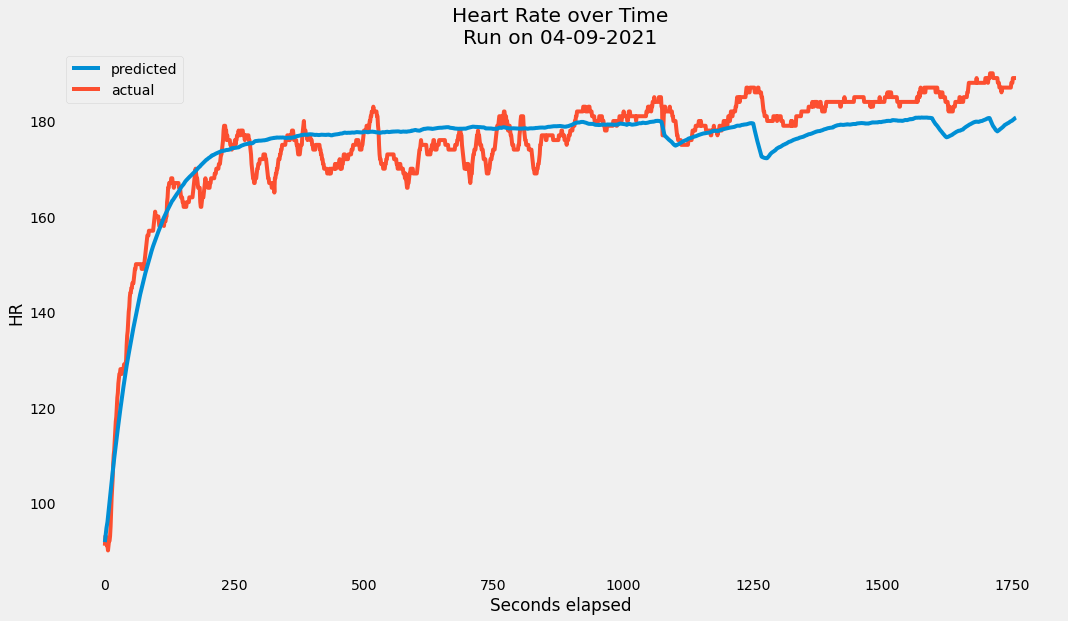

In [19]:
test = (pd.read_excel('Run Test.xlsx', converters = {'ns1:time': pd.to_datetime, 'ns1:time2': pd.to_datetime})
        [['ns1:time', 'lat', 'lon', 'ns1:ele', 'ns1:time2', 'ns2:hr', 'ns2:cad']])
test.rename(columns={'ns2:hr':'hr', 'ns2:cad': 'cadence'}, inplace = True)

test['depth'] = (test['ns1:time2'] - test['ns1:time']).apply(lambda x: x.total_seconds())/60

test[['prev_lat', 'prev_lon']] = test[['lat', 'lon']].shift()
test['speed'] = ((test.apply(lambda x: haversine((x['prev_lat'], x['prev_lon']), (x['lat'], x['lon'])), axis = 1))*60)
distance_vec = test['speed'].copy()
test['speed_gain'] = (test['speed'] - test['speed'].shift())

test['elev_gain'] = test['ns1:ele'] - test['ns1:ele'].shift()

test['prev_hr'] = test['hr'].shift()

cadence_change = (test['cadence'] - test['cadence'].shift()).copy().dropna()

test.drop(columns = drop_list, inplace = True)
test.dropna(inplace=True)
test.reset_index(drop=True, inplace = True)

hr = 97
hr_list = []
for i in range(len(test)):
    hr = best_mlp.predict(np.append(test.iloc[i,1:X.shape[1]], hr).reshape(1,-1))
    hr_list.append(hr[0])
    
plt.plot(hr_list, label = 'predicted', zorder = 2)
plt.plot(test['hr'], label = 'actual', zorder = 1)
plt.legend()

plt.title('Heart Rate over Time\nRun on 04-09-2021')
plt.xlabel('Seconds elapsed')
plt.ylabel('HR');

In [30]:
?make_scorer

Signature:
make_scorer(
    score_func,
    *,
    greater_is_better=True,
    needs_proba=False,
    needs_threshold=False,
    **kwargs,
)
Docstring:
Make a scorer from a performance metric or loss function.

This factory function wraps scoring functions for use in GridSearchCV
and cross_val_score. It takes a score function, such as ``accuracy_score``,
``mean_squared_error``, ``adjusted_rand_index`` or ``average_precision``
and returns a callable that scores an estimator's output.

Read more in the :ref:`User Guide <scoring>`.

Parameters
----------
score_func : callable,
    Score function (or loss function) with signature
    ``score_func(y, y_pred, **kwargs)``.

greater_is_better : boolean, default=True
    Whether score_func is a score function (default), meaning high is good,
    or a loss function, meaning low is good. In the latter case, the
    scorer object will sign-flip the outcome of the score_func.

needs_proba : boolean, default=False
    Whether score_func requires pre

In [20]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [4]:
hr0 = 96
distance = 0
speed = 1/5.9
counter = 1
speed_gain = 0

while distance <= 5:
    hr0 = mlp.predict(np.array([86, counter/60, speed, 0, hr0]).reshape(1,-1))
    # speed += speed_gain
    distance += speed/60
    print(f'Minutes: {np.round(counter/60, 2)}, HR: {np.round(hr0[0], 2)}, Distance: {np.round(distance,2)}, Speed: {speed}')
    counter += 1

Minutes: 0.02, HR: 96.5, Distance: 0.0, Speed: 0.1694915254237288
Minutes: 0.03, HR: 96.99, Distance: 0.01, Speed: 0.1694915254237288
Minutes: 0.05, HR: 97.49, Distance: 0.01, Speed: 0.1694915254237288
Minutes: 0.07, HR: 97.97, Distance: 0.01, Speed: 0.1694915254237288
Minutes: 0.08, HR: 98.46, Distance: 0.01, Speed: 0.1694915254237288
Minutes: 0.1, HR: 98.94, Distance: 0.02, Speed: 0.1694915254237288
Minutes: 0.12, HR: 99.42, Distance: 0.02, Speed: 0.1694915254237288
Minutes: 0.13, HR: 99.9, Distance: 0.02, Speed: 0.1694915254237288
Minutes: 0.15, HR: 100.37, Distance: 0.03, Speed: 0.1694915254237288
Minutes: 0.17, HR: 100.85, Distance: 0.03, Speed: 0.1694915254237288
Minutes: 0.18, HR: 101.31, Distance: 0.03, Speed: 0.1694915254237288
Minutes: 0.2, HR: 101.78, Distance: 0.03, Speed: 0.1694915254237288
Minutes: 0.22, HR: 102.24, Distance: 0.04, Speed: 0.1694915254237288
Minutes: 0.23, HR: 102.7, Distance: 0.04, Speed: 0.1694915254237288
Minutes: 0.25, HR: 103.16, Distance: 0.04, Speed